In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [15, 7]
import seaborn as sns

In [ ]:
from jupyterthemes import get_themes
import jupyterthemes as jt
from jupyterthemes.stylefx import set_nb_theme

In [ ]:
set_nb_theme("chesterish")

In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% ! important; }<style>"))

In [2]:
def print_xml_tree(element, indent=' '):
    if isinstance(element, dict):
        for key, value in element.items():
            if isinstance(value, (dict, list)):
                print(f"{indent}{key}:")
                print_xml_tree(value, indent + "  ")
            else:
                print(f"{indent}{key}: {value}")

    else:
        print(f'{indent}{element}')

In [3]:
import xml.etree.ElementTree as ET
import xmltodict
import json
import os

doc = xmltodict.parse(open('./Oxford_Pet_Dataset/annotations/xmls/Abyssinian_100.xml').read())

print_xml_tree(doc)

 annotation:
   folder: OXIIIT
   filename: Abyssinian_100.jpg
   source:
     database: OXFORD-IIIT Pet Dataset
     annotation: OXIIIT
     image: flickr
   size:
     width: 394
     height: 500
     depth: 3
   segmented: 0
   object:
     name: cat
     pose: Frontal
     truncated: 0
     occluded: 0
     bndbox:
       xmin: 151
       ymin: 71
       xmax: 335
       ymax: 267
     difficult: 0


In [4]:
def mask_to_bbox(img):
    rows = np.any(img == 1, axis=1)
    cols = np.any(img == 1, axis=0)
    ymin, ymax = np.where(rows)[0][[0, -1]]
    xmin, xmax = np.where(cols)[0][[0, -1]]

    return max(xmin - 15, 0), min(xmax + 15, img.shape[1]), max(ymin - 15, 0), min(ymax + 15, img.shape[0])

In [5]:
from pycocotools import mask

def generateVOC2Json(rootDir, xmlFiles):
    attrDict = {}
    attrDict['categories'] = [
        {'supercategory':'none', 'id':0, 'name':'cat'},
        {'supercategory':'none', 'id':1, 'name':'dog'}
    ]
    
    images = []
    annotations = []
    annotation_id = 0
    
    for root, dirs, files in os.walk(rootDir):
        image_id = 0
        for file in xmlFiles:
            image_id += 1
            if file in files:
                try:
                    path = root + file
                    image = {}
                    doc = xmltodict.parse(open(path).read())
                    image['file_name'] = doc['annotation']['filename']
                    image['height'] = int(doc['annotation']['size']['height'])
                    image['width'] = int(doc['annotation']['size']['width'])
                    image['sem_seg_file_name'] = root[:-5] + 'trimaps/' + file[:-4] + '.png'
                    image['id'] = image_id
                    images.append(image)

                    if 'object' in doc['annotation']:
                        obj = doc['annotation']['object']
                        for value in attrDict['categories']:
                            annotation = {}
                            if obj['name'] == value['name']:
                                annotation['iscrowd'] = 0
                                annotation['image_id'] = image_id
                                annotation['category_id'] = value['id']
                                annotation['ignore'] = 0
                                annotation['id'] = annotation_id
                                
                                image_mask = cv2.imread(image['sem_seg_file_name'])
                                xmin, xmax, ymin, ymax = mask_to_bbox(image_mask[:, :, 0])
                                
                                image_mask = np.where(image_mask==3, 1, image_mask)
                                image_mask = np.where(image_mask==2, 0, image_mask)
                                image_mask = image_mask.astype('uint8')

                                segmask = mask.encode(np.asarray(image_mask, order='F'))
                                for seg in segmask:
                                    seg['counts'] = seg['counts'].decode('utf-8')
                                
                                x1 = int(xmin)
                                y1 = int(ymin)
                                x2 = int(xmax - x1)
                                y2 = int(ymax - y1)

                                annotation['bbox'] = [x1, y1, x2, y2]
                                annotation['area'] = float(x2 * y2)
                                annotation['segmentation'] = segmask[0]
                                
                                annotation_id += 1
                                annotations.append(annotation)
                        
                    else:
                        print(f'File: {file} does not have any object')    
                except:
                    pass
            else:
                print(f'File {file} not found')
        
    attrDict['images'] = images
    attrDict['annotations'] = annotations
    jsonString = json.dumps(attrDict)
        
    return jsonString

In [6]:
import cv2

rootDir = './Oxford_Pet_Dataset/annotations/xmls/'
trainFile = './Oxford_Pet_Dataset/annotations/trainval.txt'
xmlFiles = []

with open(trainFile, 'r') as f:
    for line in f:
        fileName = line.strip().split()[0]
        xmlFiles.append(fileName + '.xml')

train_xmlFiles = generateVOC2Json(rootDir, xmlFiles)

File Abyssinian_104.xml not found
File Bengal_111.xml not found
File samoyed_10.xml not found
File Bengal_175.xml not found
File Egyptian_Mau_14.xml not found
File Egyptian_Mau_156.xml not found
File Egyptian_Mau_186.xml not found
File Ragdoll_199.xml not found
File saint_bernard_15.xml not found


In [7]:
with open('./Oxford_Pet_Dataset/annotations/train_segment.json', 'w') as f:
    f.write(train_xmlFiles)

In [ ]:
from detectron2.data.datasets import register_coco_instances
from detectron2.data import MetadataCatalog
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

train = 'train'
test = 'test'

image_root = './Oxford_Pet_Dataset/images'
train_json = './Oxford_Pet_Dataset/annotations/train_segment.json'

register_coco_instances(train, {}, train_json, image_root)
metadata = MetadataCatalog.get(train)

cfg = get_cfg()
cfg.merge_from_file('C:/Users/phuc2/anaconda3/envs/cuda_env/Lib/site-packages/detectron2/model_zoo/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_1x.yaml')
cfg.DATASETS.TRAIN = (train,)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.CHECKPOINT_PERIOD = 500
cfg.SOLVER.BASE_LR = 0.0001
cfg.SOLVER.MAX_ITER = 5000
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 4  
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2
cfg.OUTPUT_DIR = './Oxford_Pet_Dataset/'
cfg.INPUT.MASK_FORMAT = 'bitmask'

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

In [9]:
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.utils.visualizer import Visualizer
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.config import get_cfg
from detectron2.data.datasets import register_coco_instances

train = 'test'

image_root = './Oxford_Pet_Dataset/images'
train_json = './Oxford_Pet_Dataset/annotations/train_segment.json'

register_coco_instances(train, {}, train_json, image_root)
metadata = MetadataCatalog.get(train)

cfg = get_cfg()
cfg.merge_from_file('C:/Users/phuc2/anaconda3/envs/cuda_env/Lib/site-packages/detectron2/model_zoo/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_1x.yaml')
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 4  
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8
cfg.OUTPUT_DIR = './Oxford_Pet_Dataset/'
cfg.INPUT.MASK_FORMAT = 'bitmask'
cfg.MODEL.WEIGHTS = cfg.OUTPUT_DIR + 'model_0001999.pth'

predictor = DefaultPredictor(cfg)
dicts = DatasetCatalog.get(train)


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



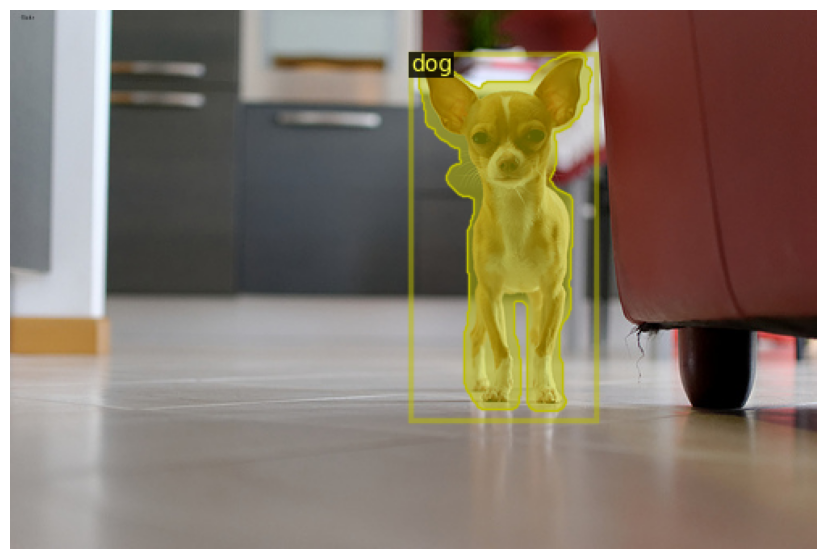

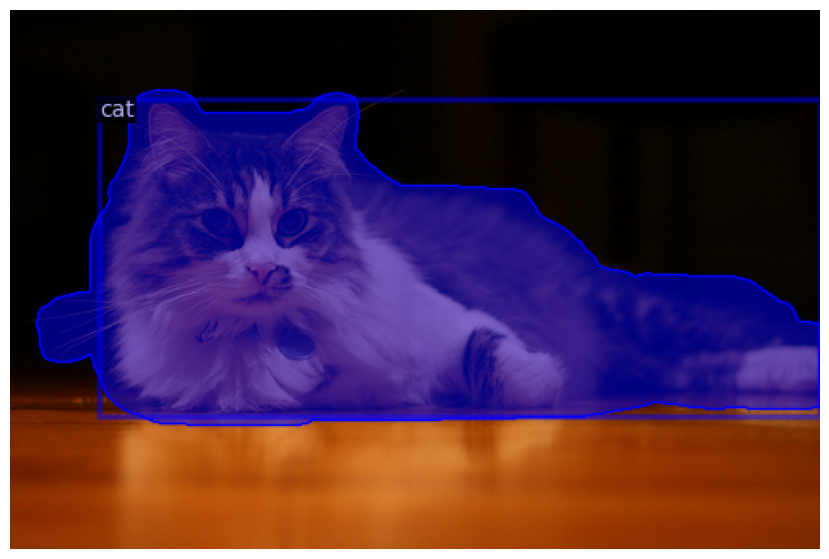

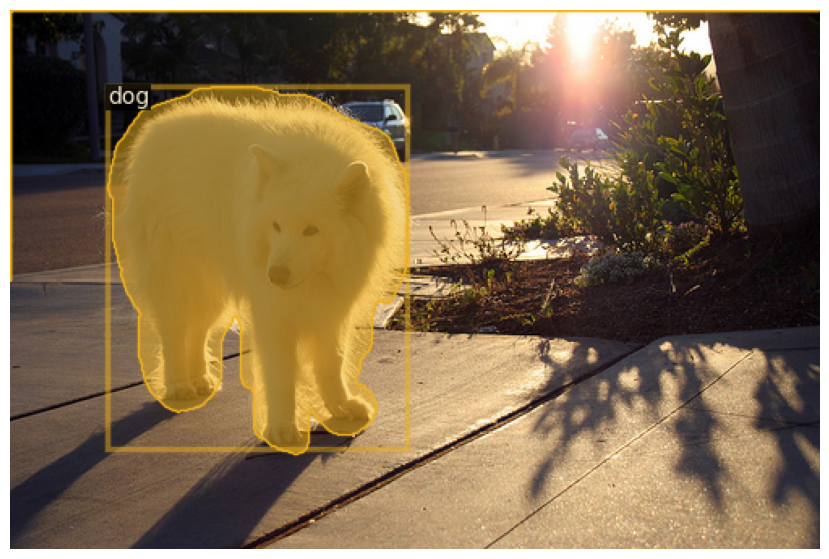

In [10]:
import random

for d in random.sample(dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata)
    vis = visualizer.draw_dataset_dict(d)
    
    plt.figure()
    plt.imshow(vis.get_image())
    plt.axis('off')

(-0.5, 639.5, 671.5, -0.5)

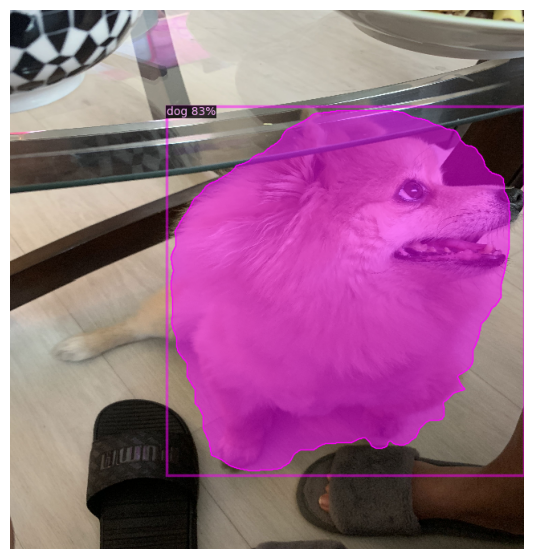

In [11]:
import torch

lu = cv2.imread("C:/Users/phuc2/Downloads/IMG_2322.jpg")
lu = cv2.resize(lu, (cfg.INPUT.MIN_SIZE_TRAIN[0], cfg.INPUT.MIN_SIZE_TRAIN[1]))

outputs_lu = predictor(lu)
visualizer_lu = Visualizer(lu[:,:,::-1], metadata)
vis_lu = visualizer_lu.draw_instance_predictions(outputs_lu['instances'].to('cpu'))

plt.imshow(vis_lu.get_image())
plt.axis('off')

In [12]:
print(cfg)

CUDNN_BENCHMARK: False
DATALOADER:
  ASPECT_RATIO_GROUPING: True
  FILTER_EMPTY_ANNOTATIONS: True
  NUM_WORKERS: 2
  REPEAT_THRESHOLD: 0.0
  SAMPLER_TRAIN: TrainingSampler
DATASETS:
  PRECOMPUTED_PROPOSAL_TOPK_TEST: 1000
  PRECOMPUTED_PROPOSAL_TOPK_TRAIN: 2000
  PROPOSAL_FILES_TEST: ()
  PROPOSAL_FILES_TRAIN: ()
  TEST: ('coco_2017_val',)
  TRAIN: ('coco_2017_train',)
GLOBAL:
  HACK: 1.0
INPUT:
  CROP:
    ENABLED: False
    SIZE: [0.9, 0.9]
    TYPE: relative_range
  FORMAT: BGR
  MASK_FORMAT: bitmask
  MAX_SIZE_TEST: 1333
  MAX_SIZE_TRAIN: 1333
  MIN_SIZE_TEST: 800
  MIN_SIZE_TRAIN: (640, 672, 704, 736, 768, 800)
  MIN_SIZE_TRAIN_SAMPLING: choice
  RANDOM_FLIP: horizontal
MODEL:
  ANCHOR_GENERATOR:
    ANGLES: [[-90, 0, 90]]
    ASPECT_RATIOS: [[0.5, 1.0, 2.0]]
    NAME: DefaultAnchorGenerator
    OFFSET: 0.0
    SIZES: [[32], [64], [128], [256], [512]]
  BACKBONE:
    FREEZE_AT: 2
    NAME: build_resnet_fpn_backbone
  DEVICE: cuda
  FPN:
    FUSE_TYPE: sum
    IN_FEATURES: ['res2', 